# 第6章 大样本OLS

## 6.4 蒙特卡洛模拟中心极限定理

<Axes: ylabel='Density'>

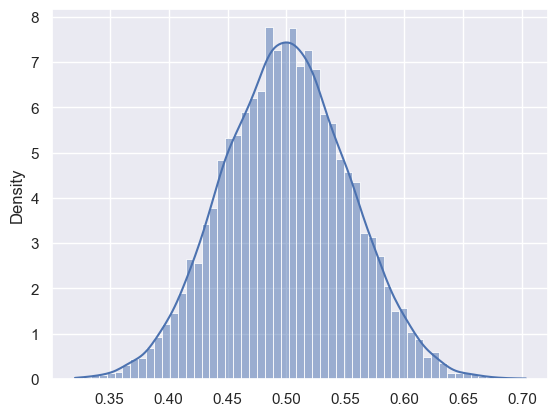

In [78]:
import seaborn as sns
import numpy as np
from scipy.stats import norm
np.random.seed(123123)

x_mean = np.array([])

def generate_x_i(obs):
    x_i = np.random.uniform(0, 1, obs)
    return x_i.mean()

for i in range(10000):
    x_mean = np.append(x_mean,generate_x_i(30))

sns.set_theme(color_codes=True)
sns.histplot(x_mean,kde=True,stat='density',alpha=0.5)


# 这里曲线图并非对应的正态分布图，后面再来画